I donwloaded recent water level observations from this website.
http://www.pac.dfo-mpo.gc.ca/science/charts-cartes/obs-app/observed-eng.aspx?StationID=07795

For comparison with nowcast or nowcast-green.

In [1]:
import pandas as pd
from dateutil import tz
import datetime
import numpy as np
import os
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np

from nowcast import figures, analyze
%matplotlib inline

In [2]:
def dateparse(s):
    """Function to make datetime object aware of time zone
    e.g. date_parser=dateParserMeasured('2014-05-31 11:42')

    :arg s: string of date and time
    :type s: str

    :returns: datetime object that is timezone aware
    """
    PST_tz = tz.tzoffset("PST", -28800)
    # Convert the string to a datetime object
    unaware = datetime.datetime.strptime(s, "%Y-%m-%d %H:%M")
    # Add in the local time zone (Canada/Pacific)
    aware = unaware.replace(tzinfo=PST_tz)
    # Convert to UTC
    return aware.astimezone(tz.tzutc())

In [3]:
data = pd.read_csv('PA_Jan.csv',parse_dates=[1],date_parser=dateparse)
data=data.rename(columns={'TIME_TAG PST (Z+8)': 'time'})
series = pd.Series(np.array(data['ENCODER2']), index = data['time'])
series=series.resample('15T')

In [4]:
def load_model_ssh(grid):
    ssh = grid.variables['sossheig'][:, 0, 0]
    time = grid.variables['time_counter']
    dates=nc.num2date(time[:], time.units)
    return ssh, dates

In [5]:
nowcast = '/results/SalishSea/nowcast/'
nowcast_green = '/results/SalishSea/nowcast-green/'
location = 'PointAtkinson'
tides_path = '/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/tidal_predictions/'
sdt = datetime.datetime(2016,1,1)
edt = datetime.datetime(2016,2,17)

labels={nowcast: 'nowcast', nowcast_green: 'nowcast-green'}

numdays = (edt-sdt).total_seconds()/86400
dates = [sdt + datetime.timedelta(days=d) for d in np.arange(numdays+1) ]

ssh = {}
time = {}
ssh_corr={}
runs = [nowcast, nowcast_green]
tides = figures.get_tides('Point Atkinson',path=tides_path)
for run in runs:
    ssh[run] = np.array([])
    time[run] = np.array([])
    for d in dates:
        fname = os.path.join(run, d.strftime('%d%b%y').lower(), '{}.nc'.format(location))
        grid = nc.Dataset(fname)
        s,t = load_model_ssh(grid)
        ssh[run]=np.append(ssh[run],s)
        time[run]=np.append(time[run],t)
    time[run] = np.array([da.replace(tzinfo=tz.tzutc()) for da in time[run]])
    ssh_corr[run] = figures.correct_model_ssh(ssh[run], time[run],tides )

## Interpolate observations to model times

In [6]:
obs_interp={}
for run in runs:
    obs_interp[run] = figures.interp_to_model_time(time[run], series, series.index)
    obs_interp[run] = np.array(obs_interp[run]) - figures.SITES['Point Atkinson']['msl']

## compare corrected water levels - observed, nowcast, nowcast-green

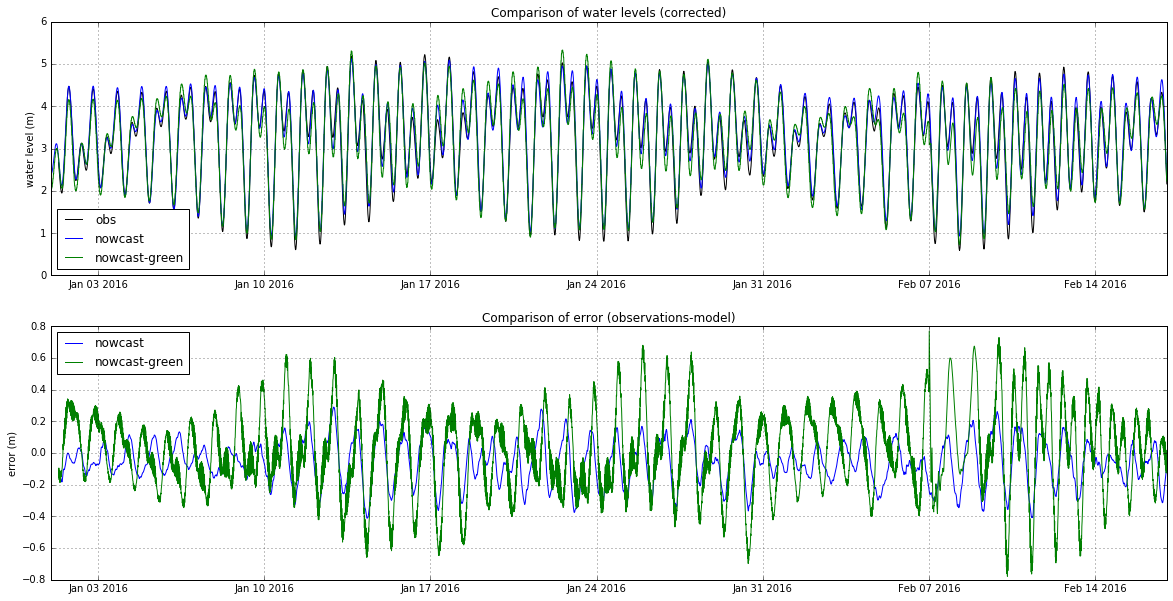

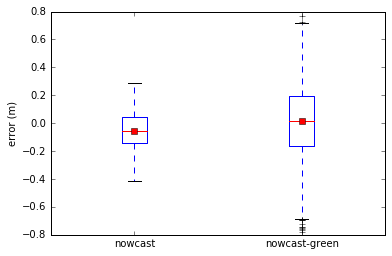

In [7]:
fig,axs=plt.subplots(2,1,figsize=(20,10))
ax=axs[0]
ax.plot(series.index, series, 'k',label='obs')
for run in runs:
    ax.plot(time[run],ssh[run]+figures.SITES['Point Atkinson']['msl'], label=labels[run])
ax.set_ylabel('water level (m)')
ax.grid()
ax.legend(loc=0)
ax.set_xlim([sdt,edt])
ax.set_title('Comparison of water levels (corrected)')

#error
errors={}
ax=axs[1]
for run in runs:
    errors[run] = obs_interp[run]-ssh[run]
    errors[run] = errors[run][~np.isnan(errors[run])]
    ax.plot(time[run],obs_interp[run]-ssh[run], label=labels[run])

ax.set_ylabel('error (m)')
ax.grid()
ax.legend(loc=0)
ax.set_xlim([sdt,edt])
ax.set_title('Comparison of error (observations-model)')

fig,ax=plt.subplots(1,1)
ax.boxplot([errors[nowcast], errors[nowcast_green]],showmeans=True)
ax.set_xticklabels([labels[nowcast],labels[nowcast_green]])
ax.set_ylabel('error (m)')

* Are we sure we have the tides tuned well in nowcast-green?
* Big picture tides look good (Spring/neap, timing of highs/lows)
* It's hard know without a longer time series but the big shock in the system around Feb 8 seems to get better with time. Errors are a lot lower on Feb 17/18. But I didn't think it takes so long for the ssh to adjust... It could be deceiving because there are other points in the time series that exhibit a similar behaviour. 

Other posible errors:
* inverse barometer (do we have it?)
* surge anamoly (do we have it?)

## Zoom in on a few days
* Are we looking at phase errors or amplitude errors

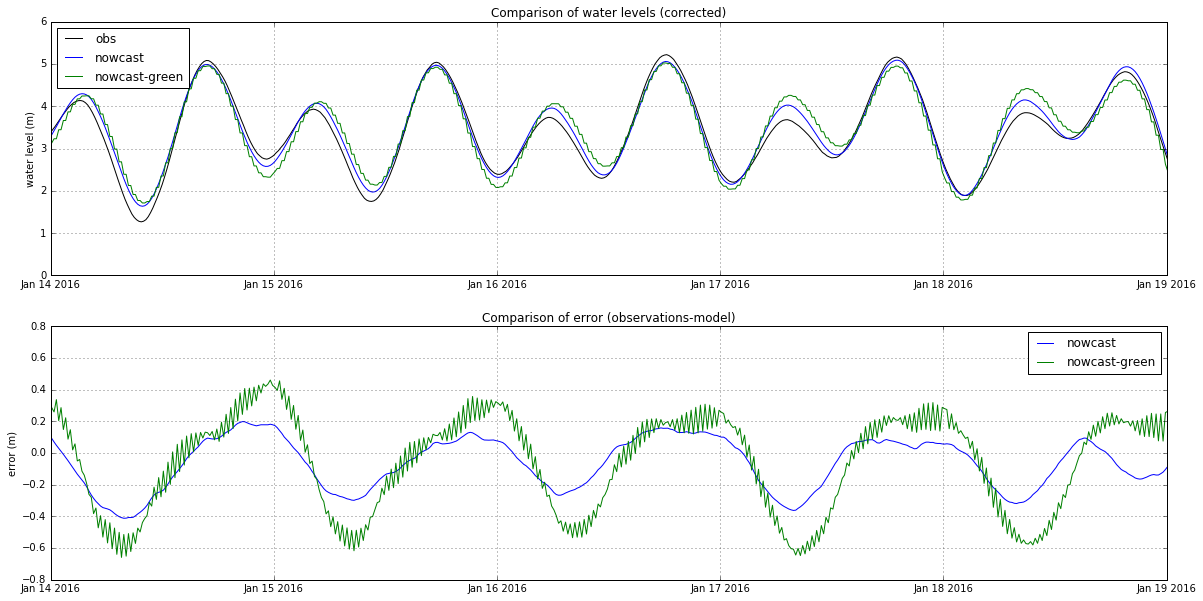

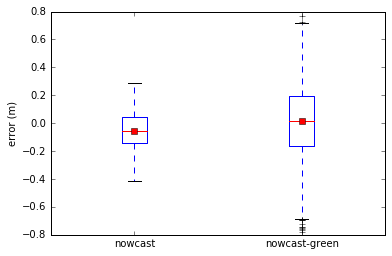

In [8]:
fig,axs=plt.subplots(2,1,figsize=(20,10))
ax=axs[0]
ax.plot(series.index, series, 'k',label='obs')
for run in runs:
    ax.plot(time[run],ssh[run]+figures.SITES['Point Atkinson']['msl'], label=labels[run])
ax.set_ylabel('water level (m)')
ax.grid()
ax.legend(loc=0)
ax.set_xlim([datetime.datetime(2016,1,14),datetime.datetime(2016,1,19)])
ax.set_title('Comparison of water levels (corrected)')

#error
errors={}
ax=axs[1]
for run in runs:
    errors[run] = obs_interp[run]-ssh[run]
    errors[run] = errors[run][~np.isnan(errors[run])]
    ax.plot(time[run],obs_interp[run]-ssh[run], label=labels[run])

ax.set_ylabel('error (m)')
ax.grid()
ax.legend(loc=0)
ax.set_xlim([datetime.datetime(2016,1,14),datetime.datetime(2016,1,19)])
ax.set_title('Comparison of error (observations-model)')

fig,ax=plt.subplots(1,1)
ax.boxplot([errors[nowcast], errors[nowcast_green]],showmeans=True)
ax.set_xticklabels([labels[nowcast],labels[nowcast_green]])
ax.set_ylabel('error (m)')

* Why is there high frequency variability in nowcasyt green? Both should be 15 minute output.
* The phase looks good (mostly), but the range is a problem.

### Spectrum of error

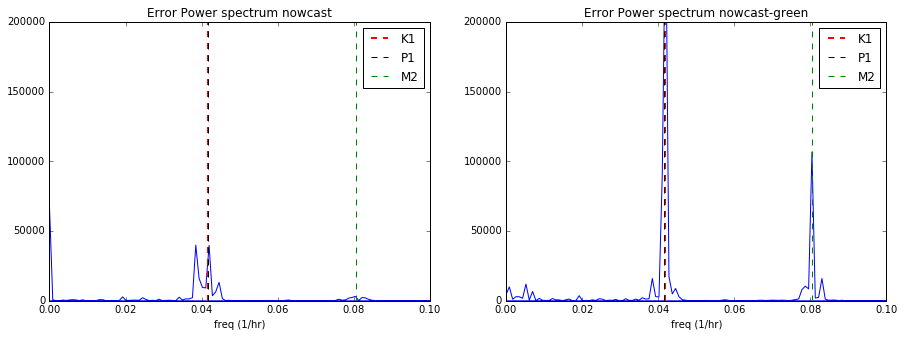

In [21]:
# model
M2_freq=28.984106/360
K1_freq = 15.041069000/360
P1_freq = 14.9589314/360
fig,axs=plt.subplots(1,2,figsize=(15,5))
for ax, run in zip(axs,runs):
    ps = np.abs(np.fft.fft((errors[run])))**2
    freqs = np.fft.fftfreq(errors[run].size, .25)
    ax.plot(freqs,ps)
    ax.set_ylim([0,2*10**5])
    ax.set_xlim([0,.1])
    ax.set_xlabel('freq (1/hr)')
    ax.set_title('Error Power spectrum {}'.format(labels[run]))
    ax.plot([K1_freq,K1_freq],[0,2*10**5],'r--',label='K1',lw=2)
    ax.plot([P1_freq,P1_freq],[0,2*10**5],'k--',label='P1')
    ax.plot([M2_freq,M2_freq],[0,2*10**5],'g--',label='M2')
    ax.legend()

* Both nowcast and  nowcast-green errors have large signals at diurnal frequency, especially K1.
* Also some signal at semi-dirunal M2 frequency in nowcast-green. Not as much in nowcast.

## Residuals

In [10]:
model_res={}
for run in runs:
    model_res[run] =figures.compute_residual(ssh_corr[run], time[run], tides)
obs_res = figures.compute_residual(obs_interp[run], time[run], tides)

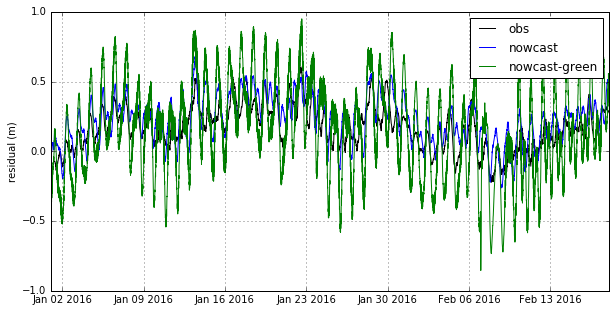

In [11]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(time[run], obs_res, 'k',label='obs')
for run in runs:
    ax.plot(time[run], model_res[run], label=labels[run])
ax.set_ylabel('residual (m)')
ax.grid()
ax.legend()

* Nowcast-green residual is dominated by tidal error but you can still see a pattern.
* Remember, there is still some tidal energy in the observed residual and nowcast residual because of the tidal predictions. 

### Daily mean residual

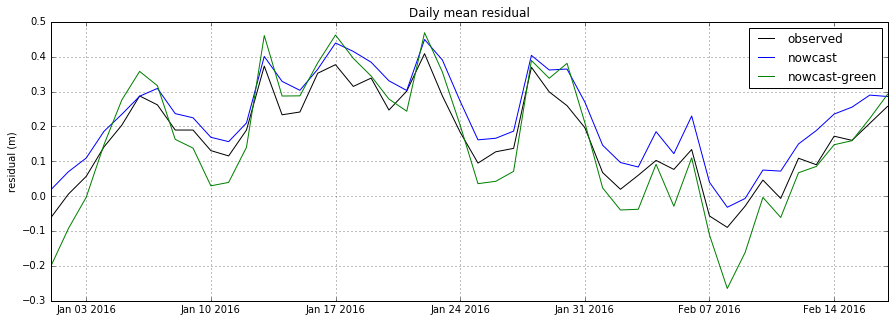

In [12]:
green=pd.DataFrame(data=model_res[nowcast_green], index=time[nowcast_green])
green = green.resample('1d')

now=pd.DataFrame(data=model_res[nowcast], index=time[nowcast])
now = now.resample('1d')

obs_data = pd.DataFrame(data=obs_res, index=time[nowcast])
obs_data = obs_data.resample('1d')

fig,ax=plt.subplots(1,1,figsize=(15,5))
ax.plot(obs_data.index, obs_data, 'k',label='observed')
ax.plot(now.index, now,label='nowcast')
ax.plot(green.index, green,label='nowcast-green')
ax.legend(loc=0)
ax.grid()
ax.set_ylabel('residual (m)')
ax.set_title('Daily mean residual')

# Summary
* Something is still off with the tides, probably the amplitudes, especially for K1. 
* How does NEMO 3.6 handle nodal corrections? Are we managing that correctly in our tidal analysis?